In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [10]:
scale = 0.01
w1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
w2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
w3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
w4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [w1, b1, w2, b2, w3, b3, w4, b4]
def lenet(X, params):
    # F.conv2d()函数的参数讲解：
    # input：输入图像
    # weight：有四个参数，第一个表示输出通道数，第二个表示输入通道数，第三个和第四个表示卷积核的大小
    # stride和padding未显示设置，因此采用默认值
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) +params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat
loss = nn.CrossEntropyLoss(reduction='none')

In [14]:
# 将所有参数放在某个指定设备上
def get_params(params, device):
    new_params = [p.to(device) for p in params]
    # 需要对每个参数求梯度
    for p in new_params:
        p.requires_grad_()
    return new_params

In [15]:
new_params = get_params(params, d2l.try_gpu(0))
print('b1权重：', new_params[1])
print('b1梯度：', new_params[1].grad)

b1权重： tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)
b1梯度： None


In [29]:
# 累加不同GPU得出的梯度，并将其广播给所有GPU
def allreduce(data):
    for i in range(1, len(data)):
        data[0] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i] = data[0].to(data[i].device)
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('allreduce之前：\n', data[0], '\n', data[1])
allreduce(data)
print('allreduce之后：\n', data[0], '\n', data[1])

allreduce之前：
 tensor([[1., 1.]]) 
 tensor([[2., 2.]])
allreduce之后：
 tensor([[3., 3.]]) 
 tensor([[3., 3.]])


In [33]:
# 将一个小批量均匀地分布在多个GPU上
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
# 并行 分散器 样本均匀分开，余数放到最后一个GPU上
split = nn.parallel.scatter(data, devices)
print('input : ', data)
print('load into', devices)
print('output: ', split)
# 在安装Pytorch时如果cpu版本的，不是gpu版本的。会提示AttributeError module 'torch._C' has no attribute '_cuda_setDevice'
# 但是代码没问题，只不过我本机跑不了，大家可以放到服务器上去跑

AttributeError: module 'torch._C' has no attribute '_scatter'

#### 正确输出：
![](images/image21.jpg)

In [34]:
def split_batch(X, y, devices):
    '''
    将X和y拆分到多个GPU上
    '''
    # 样本数量和标签数量要相等
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))

In [35]:
# 在一个小批量上实现多GPU训练
def train_batch(X, y, device_params, devices, lr):
    # 将X和y拆分到多个设备上
    X_shards, y_shards = split_batch(X, y, devices)
    # 对每个GPU上的数据块计算损失函数值
    # 样本和标签，被均匀分散到不同设备
    # 参数和模型也要传到对应的设备上
    # 不同设备上的参数和模型是一致的
    ls = [loss(lenet(X_shard, device_param), y_shard).sum()
               for X_shard, y_shard, device_param
               in zip(X_shards, y_shards, device_params)]
    # 每个设备的损失单独反向传播
    for l in ls:
        l.backward()
    # 进行梯度累加，并传播给不同的GPU
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce([device_params[c][i].grad for c in range(len(devices))])
    # 优化函数
    # 对不同设备上的参数，调用相同的优化函数
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0])

In [37]:
# 定义训练函数
def train(num_gpus, batch_size, lr):
    # 数据
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    # 设备
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    # 参数
    device_params = [get_params(params, d) for d in devices]
    # 超参数
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            train_batch(X, y, device_params, devices, lr)
            # 同步，等待
            torch.cuda.synchronize()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}, {timer.avg():.1f}秒/轮',
          f'在{str(devices)}')

ValueError: Expected a non cpu device, but got: cpu

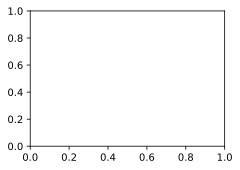

In [38]:
train(1, 256, 0.2)

## 以下是在GPU上跑得的结果：

In [ ]:
train(num_gpus=1, batch_size=256, lr=0.2)

![](images/image23.jpg)

In [ ]:
# 多gpu数据并行训练，速度没有变快
# 原因1：数据IO时间>>计算时间
# 原因2：小批量被切成数据块，每个gpu处理的数据变少，不能充分利用gpu的计算能力。
# 处理2：还是保证每个gpu拿到相同大小的mini_batch_size，加大lr
# 原因3：从0开始写的代码，pytorch 不能很好的多gpu
# 原因4：LeNet网络模型容量小，复杂度不够
train(num_gpus=2, batch_size=256*2, lr=0.2)

![](images/image24.jpg)